In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon
from copy import deepcopy
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, f1_score, mean_squared_error, roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [220]:
train = pd.read_csv('training.csv')

In [121]:
# Check number of rows and columns
print(train.shape)

(12906, 83)


In [89]:
train.describe()

,patient_id,patient_zip3,patient_age,bmi,population,density,age_median,age_under_10,age_10_to_19,age_20s,...,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Ozone,PM25,N02,DiagPeriodL90D
count,12906.000000,12906.000000,12906.000000,3941.000000,12905.000000,12905.000000,12905.000000,12905.000000,12905.000000,12905.000000,...,12905.000000,12902.000000,12902.000000,12905.000000,12905.000000,12905.000000,12877.000000,12877.000000,12877.000000,12906.000000
mean,547381.196033,573.754300,59.183326,28.984539,20744.441237,1581.950419,40.502259,11.122784,12.945265,13.290376,...,13.335299,13.406950,4.474956,27.978387,8.575284,7.083376,39.822352,7.475221,16.098988,0.624516
std,260404.959974,275.447534,13.335216,5.696906,13886.903756,2966.305306,4.036963,1.512376,1.923974,3.354103,...,3.690949,5.222495,4.837085,5.083939,4.203482,3.109022,3.559492,1.516499,5.842501,0.484266
min,100063.000000,101.000000,18.000000,14.000000,635.545455,0.916667,20.600000,0.000000,6.314286,5.925000,...,4.600000,3.433333,0.000000,12.460784,2.440000,1.200000,30.939316,2.636008,2.760371,0.000000
25%,321517.000000,331.000000,50.000000,24.660000,9463.896552,171.857143,37.129825,10.160000,11.741176,11.013415,...,10.270492,9.663333,0.994444,24.933333,5.618750,4.929688,37.698880,6.651215,11.280694,0.000000
50%,543522.000000,554.000000,59.000000,28.190000,19154.190480,700.337500,40.639344,11.039216,12.923944,12.538095,...,12.884000,12.177778,2.747222,27.788235,7.465714,6.847059,39.108249,7.686577,15.589148,1.000000
75%,772671.750000,846.000000,67.000000,32.920000,30021.278690,1666.515385,42.934783,12.190000,14.019767,14.971053,...,15.555405,16.635556,5.976000,30.709375,10.617442,8.620000,41.136513,8.276922,20.801880,1.000000
max,999896.000000,999.000000,91.000000,85.000000,71374.131580,21172.000000,54.570000,17.675000,35.300000,62.100000,...,35.155556,38.347826,26.755000,48.020000,27.566102,25.200000,52.237210,11.169408,31.504775,1.000000


In [87]:
train['patient_zip3'] = train['patient_zip3'].astype(str).str.zfill(5)

In [123]:
# Check the number of NA in each column
train.isna().sum().sort_values(ascending=False)

metastatic_first_novel_treatment         12882
metastatic_first_novel_treatment_type    12882
bmi                                       8965
patient_race                              6385
payer_type                                1803
                                         ...  
breast_cancer_diagnosis_code                 0
patient_gender                               0
patient_age                                  0
patient_zip3                                 0
DiagPeriodL90D                               0
Length: 83, dtype: int64

In [221]:
# Remove the columns with more than 50% of NA and drop the columns that are not useful (ID, desc)
#train = train.drop(columns=['metastatic_first_novel_treatment', 'metastatic_first_novel_treatment_type', 'bmi', 'patient_id', 'breast_cancer_diagnosis_desc'])

# Check the number of NA in each row
train.isna().sum(axis=1).sort_values(ascending=False)

# Remove the rows with more than 5 NA values
train = train.dropna(thresh=74)

# Columns to drop
columns_to_drop = ['metastatic_first_novel_treatment', 'metastatic_first_novel_treatment_type', 'bmi', 'patient_id', 'breast_cancer_diagnosis_desc',
                   'age_median','age_under_10',	'age_10_to_19',	'age_20s',	'age_30s',	'age_40s',	'age_50s',	'age_60s',	'age_70s'	,'age_over_80'	,'male','female',
                   'Division', 'patient_zip3','patient_state', 'Region'#, 'metastatic_cancer_diagnosis_code'
                   ]
train = train.drop(columns_to_drop, axis=1)

## EDA

In [52]:
# Check number of each category in each column
train['DiagPeriodL90D'].value_counts()

# Dataset is skewed

1    8058
0    4843
Name: DiagPeriodL90D, dtype: int64

In [ ]:
# Create a heat map visualization of DiagPeriodL90D by zip code

## Handle Imbalance

In [127]:
from sklearn.utils import resample
#create two different dataframe of majority and minority class 
df_majority = train[(train['DiagPeriodL90D']==1)] 
df_minority = train[(train['DiagPeriodL90D']==0)] 
# upsample minority class
df_majority_downsampled = resample(df_majority, 
                                 replace=True,    # sample with replacement
                                 n_samples= 5000, # to match minority class
                                 random_state=42)  # reproducible results
# Combine majority class with upsampled minority class
train = pd.concat([df_majority_downsampled, df_minority])

## Data Processing 1

In [222]:
# Define features and target variable
X = deepcopy(train.drop(columns=['DiagPeriodL90D']))
# make y a dataframe
y = deepcopy(pd.DataFrame(train['DiagPeriodL90D']))


# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.7, random_state=42)

In [52]:
# Create an instance of RandomUnderSampler
#undersampler = RandomUnderSampler(random_state=42)

# Fit and apply the undersampler to the training data
#X_train, y_train = undersampler.fit_resample(X_train, y_train)

In [ ]:
# Create a transformer for the categorical columns and the numerical columns together


In [223]:
# Build a transformer for the categorical columns and the numerical columns (impute and scale) together
def process_features(df):
    categorical_columns = df.select_dtypes(include='object').columns
    numeric_features = df.select_dtypes(include=['int64', 'float64']).columns

    pipeline_cat = Pipeline(
        steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))]
    )

    pipeline_num = Pipeline(
        steps=[('imputer', SimpleImputer(strategy='mean')), ('scaler', MinMaxScaler())]
    )

    preprocessor = ColumnTransformer(
        transformers=[
            ("cat", pipeline_cat, categorical_columns),
            ("num", pipeline_num, numeric_features)
        ]
    )

    return preprocessor

In [224]:
# Apply transformer
preprocessor_train = process_features(X_train)
X_train = preprocessor_train.fit_transform(X_train)
X_val = preprocessor_train.transform(X_val)

In [225]:
X_train = pd.DataFrame(X_train, columns=preprocessor_train.get_feature_names_out())
X_val = pd.DataFrame(X_val, columns=preprocessor_train.get_feature_names_out())

In [226]:
# check type and shape of X_train
print(type(X_train))
print(X_train.shape)
print(X_val.shape)

<class 'pandas.core.frame.DataFrame'>
(3870, 142)
(9031, 142)


## Linear Regression

In [153]:
X_train_array = X_train.toarray()
X_val_array = X_val.toarray()

In [ ]:
# Fit the OLS model
model = sm.OLS(y_train, X_train_array)
results = model.fit()

# Print the regression results
print(results.summary())

In [ ]:
# Make prediction on test set
y_pred = results.predict(X_val_array)

# Compute R-squared for test set
r2_score(y_pred, y_val)

In [23]:
# Confidence interval
conf_int = results.conf_int()

# Filter features based on confidence intervals
not_significant = (conf_int[0]) > 0 & (conf_int[1] < 0)

len(not_significant[not_significant==True])/len(not_significant)
# 6% of the features are not significant based on the CI

0.06129398410896708

In [ ]:
# Remove insignificant features based on their confidence intervals
X_train_sign = X_train_array[:, ~not_significant]
X_val_sign = X_val_array[:, ~not_significant]

# Refit the linear regression
model2 = sm.OLS(y_train, X_train_sign)
results2 = model2.fit()
print(results2.summary())

In [22]:
# Make prediction on test set
y_pred_sign = results2.predict(X_val_sign)

# Compute R-squared
r2_score(y_pred_sign, y_val)

-0.4734966974659207

## XGBoost

In [227]:
import xgboost as xgb

# Create an XGBoost classifier
xgb_classifier = xgb.XGBClassifier()

# Define a grid of hyperparameters to search over
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1], 
    'n_estimators': [100, 200, 300]
}

In [17]:
# Create a GridSearchCV object to find the best hyperparameters with MSE
grid_search = GridSearchCV(xgb_classifier, param_grid, cv=5, scoring='roc_auc')

In [228]:
# Fit the model to the data and find the best hyperparameters
grid_search.fit(X_train, y_train)  # X and y are your data and labels

# Get the best parameters and the best estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

Fitting 5 folds for each of 27 candidates, totalling 135 fits


In [229]:
# Make prediction on the test data
y_pred_val = best_estimator.predict(X_val)

# Evaluate the model
mse = mean_squared_error(y_val, y_pred_val)

print("Best hyperparameters:", best_params)
print("f1:", f1_score(y_val, y_pred_val))
print("AUC:", roc_auc_score(y_val, y_pred_val))
print("MSE:", mean_squared_error(y_val, y_pred_val))

Best hyperparameters: {'max_depth': 20, 'min_samples_split': 30, 'n_estimators': 300}
f1: 0.8579527559055118
AUC: 0.7451270172838372
MSE: 0.1997563946406821


In [232]:
y_val

,DiagPeriodL90D
6238,0
8869,1
4660,0
8506,1
4873,0
...,...
3812,1
11231,1
3451,0
4592,1


In [234]:
confusion_matrix = pd.crosstab(y_val['DiagPeriodL90D'], y_pred_val, rownames=['Actual'], colnames=['Predicted'])
print(confusion_matrix)

print(classification_report(y_val, y_pred_val))

Predicted     0     1
Actual               
0          1779  1590
1           214  5448
              precision    recall  f1-score   support

           0       0.89      0.53      0.66      3369
           1       0.77      0.96      0.86      5662

    accuracy                           0.80      9031
   macro avg       0.83      0.75      0.76      9031
weighted avg       0.82      0.80      0.79      9031



## Test

In [235]:
test = pd.read_csv('test.csv')
test.shape

(5792, 82)

In [236]:
test['patient_zip3'] = test['patient_zip3'].astype(str).str.zfill(5)

X_test = test.drop(columns=columns_to_drop)

In [237]:
X_test = preprocessor_train.transform(test)


In [117]:
X_test = pd.DataFrame(X_test, columns=preprocessor_train.get_feature_names_out())

In [27]:
# Make prediction on the test data - XGBoost
y_pred = best_estimator.predict(X_test)

# Save the prediction to a CSV file with two columns: patient_id and DiagPeriodL90D
submission = pd.DataFrame({'patient_id': test['patient_id'], 'DiagPeriodL90D': y_pred})
submission.to_csv('submission.csv', index=False)

## Random Forest

### Modeling

In [238]:
# Define grid search
param_grid = {
    'n_estimators': [200, 300, 400],
    'max_depth': [None, 20, 30],
    'min_samples_split': [20, 25, 30]
}

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42, bootstrap=True)

# Perform the grid search
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, 
                           scoring='roc_auc', cv=5, n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)

# Get the best parameters and the best estimator
best_params = grid_search.best_params_
best_rf_model = grid_search.best_estimator_

<IPython.core.display.Javascript object>

Fitting 5 folds for each of 27 candidates, totalling 135 fits


In [239]:
step_factor = 0.05 
threshold_value = 0.2 
roc_score=0
predicted_proba = best_rf_model.predict_proba(X_val) #probability of prediction
while threshold_value <=0.6: #continue to check best threshold upto probability 0.8
    temp_thresh = threshold_value
    predicted = (predicted_proba [:,1] >= temp_thresh).astype('int') #change the class boundary for prediction
    print('Threshold',temp_thresh,'--',roc_auc_score(y_val, predicted))
    if roc_score<roc_auc_score(y_val, predicted): #store the threshold for best classification
        roc_score = roc_auc_score(y_val, predicted)
        thrsh_score = threshold_value
    threshold_value = threshold_value + step_factor
print('---Optimum Threshold ---',thrsh_score,'--ROC--',roc_score)

Threshold 0.2 -- 0.5770590866355919
Threshold 0.25 -- 0.6390721540205075
Threshold 0.3 -- 0.6872191063218056
Threshold 0.35 -- 0.7164710522174305
Threshold 0.39999999999999997 -- 0.7274646272520904
Threshold 0.44999999999999996 -- 0.7376241384267113
Threshold 0.49999999999999994 -- 0.7451270172838372
Threshold 0.5499999999999999 -- 0.7516487833099994
Threshold 0.6 -- 0.7445294899502907
---Optimum Threshold --- 0.5499999999999999 --ROC-- 0.7516487833099994


In [240]:
# Make prediction on the test data
predicted_probabilities = best_rf_model.predict_proba(X_val)

# Adjust decision threshold
custom_threshold = 0.55
y_pred_val = np.vstack((predicted_probabilities[:, 1] >= custom_threshold).astype(int))

# Calculate the F1 score for the best model
f1_score_best_model = f1_score(y_val, y_pred_val)

print("Best hyperparameters:", best_params)
print(f"F1 score for best model: {f1_score_best_model}")
print("AUC:", roc_auc_score(y_val, y_pred_val))
print("MSE:", mean_squared_error(y_val, y_pred_val))

Best hyperparameters: {'max_depth': 20, 'min_samples_split': 30, 'n_estimators': 300}
F1 score for best model: 0.8574844571975132
AUC: 0.7516487833099994
MSE: 0.19798471930018824


In [241]:
print(classification_report(y_val, y_pred_val))

              precision    recall  f1-score   support

           0       0.87      0.55      0.68      3369
           1       0.78      0.95      0.86      5662

    accuracy                           0.80      9031
   macro avg       0.82      0.75      0.77      9031
weighted avg       0.81      0.80      0.79      9031



In [242]:
# Feature importance
feature_importances = best_rf_model.feature_importances_
feature_importances_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)
inspect = pd.DataFrame(feature_importances_df[feature_importances_df['Importance'] < 0.001])

df = pd.DataFrame(columns=['feature', 'total_count', 'unimportant_count'])

for column in train.columns:
    total_count = train[column].nunique()
    unimportant_count = (inspect['Feature'].str.startswith('cat__'+column)).sum()
    new_row = {'feature':column, 'total_count': total_count, 'unimportant_count': unimportant_count}
    df = df.append(new_row, ignore_index=True)

df.sort_values(by='unimportant_count', ascending=True)

,feature,total_count,unimportant_count
30,home_value,737,0
33,education_less_highschool,727,0
34,education_highschool,731,0
35,education_some_college,730,0
36,education_bachelors,733,0
...,...,...,...
23,income_household_75_to_100,714,0
3,patient_gender,1,1
0,patient_race,5,1
4,breast_cancer_diagnosis_code,50,22


In [243]:
feature_importances_df.to_csv('feature_importance.csv', index=False)

### Test

In [210]:
test = pd.read_csv('test.csv')
X_test = test.drop(columns=columns_to_drop)
X_test = preprocessor_train.transform(test)

In [211]:
X_test = pd.DataFrame(X_test, columns=preprocessor_train.get_feature_names_out())

In [139]:
# Make prediction on the test data - Random Forest
predicted_probabilities = best_rf_model.predict_proba(X_test)

# Adjust decision threshold
#custom_threshold = 0.56
#y_pred = np.vstack((predicted_probabilities[:, 1] >= custom_threshold).astype(int))
#y_pred = pd.DataFrame(y_pred, columns=["DiagPeriodL90D"])
y_pred = pd.DataFrame(predicted_probabilities[:, 1], columns=["DiagPeriodL90D"])

# Save the prediction to a CSV file with two columns: patient_id and DiagPeriodL90D
submission = pd.DataFrame({'patient_id': test['patient_id'], 'DiagPeriodL90D': y_pred['DiagPeriodL90D']})
submission.to_csv('submission.csv', index=False)

## Logistic Regression

## H20 AutoML

In [129]:
import h2o
from h2o.automl import H2OAutoML

,DiagL90DPeriod


In [139]:
# Initialize H2O
h2o.init()

# Convert your data to H2OFrame
X_train_h2o = h2o.H2OFrame(X_train)
y_train_h2o = h2o.H2OFrame(y_train)
X_val_h2o = h2o.H2OFrame(X_val)
y_val_h2o = h2o.H2OFrame(y_val)

# Combine the features and target for training
train_data = X_train_h2o.cbind(y_train_h2o)
train_data.set_names(list(X_train.columns) + ['DiagL90DPeriod'])

# Combine the features and target for validation
val_data = X_val_h2o.cbind(y_val_h2o)
val_data.set_names(list(X_val.columns) + ['DiagL90DPeriod'])

# Identify predictors and response
x = train_data.columns[:-1]
y = 'DiagL90DPeriod'

# Run AutoML
aml = H2OAutoML(max_models=5, seed=42)
aml.train(x=x, y=y, training_frame=train_data)

# View the AutoML leaderboard
lb = aml.leaderboard
print(lb)

# Get the best model
best_model = aml.leader

# Evaluate the best model on the validation set
val_predictions = best_model.predict(val_data)
mse_score = best_model.model_performance(val_data).mse()
print(f'Mean Squared Error (MSE) on validation set: {mse_score}')

# Optionally, you can also use AUC-ROC for classification problems
# For regression, you may want to consider other metrics like R2, RMSE, etc.


Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,6 mins 08 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.3
H2O_cluster_version_age:,1 month and 28 days
H2O_cluster_name:,H2O_from_python_pnhua_n11wm4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,6.637 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


KeyboardInterrupt: 

## PyCaret

In [3]:
import pyforest
import pycaret
pycaret.__version__
from pycaret.classification import ClassificationExperiment
from pycaret.regression import RegressionExperiment

In [4]:
train2 = pd.read_csv('training.csv')
#train2['patient_zip3'] = train2['patient_zip3'].astype(str).str.zfill(5)
# Remove the rows with more than 5 NA values
train2 = train2.dropna(thresh=74)

# Columns to drop
# Columns to drop
columns_to_drop = ['metastatic_first_novel_treatment', 'metastatic_first_novel_treatment_type', 'bmi', 'patient_id', 'breast_cancer_diagnosis_desc',
                   'age_median','age_under_10',	'age_10_to_19',	'age_20s',	'age_30s',	'age_40s',	'age_50s',	'age_60s',	'age_70s'	,'age_over_80'	,'male','female',
                   #'Division', 'patient_zip3','patient_state', 'Region'#, 'metastatic_cancer_diagnosis_code'
                   ]
train2 = train2.drop(columns_to_drop, axis=1)

# Define features and target variable
X = deepcopy(train2)
# make y a dataframe
#y = deepcopy(pd.DataFrame(train['DiagPeriodL90D']))

# Apply transformer
def process_features2(df):
    categorical_columns = df.select_dtypes(include='object').columns

    pipeline_cat = Pipeline(
        steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))]
    )

    preprocessor = ColumnTransformer(
        transformers=[
            ("cat", pipeline_cat, categorical_columns)
        ]
    )

    return preprocessor
preprocessor_train2 = process_features2(X)

In [7]:
pd.DataFrame(X)

,0
0,"(0, 5)\t1.0\n (0, 7)\t1.0\n (0, 14)\t1.0\n..."
1,"(0, 4)\t1.0\n (0, 6)\t1.0\n (0, 14)\t1.0\n..."
2,"(0, 4)\t1.0\n (0, 6)\t1.0\n (0, 53)\t1.0\n..."
3,"(0, 4)\t1.0\n (0, 6)\t1.0\n (0, 14)\t1.0\n..."
4,"(0, 5)\t1.0\n (0, 6)\t1.0\n (0, 23)\t1.0\n..."
...,...
12896,"(0, 4)\t1.0\n (0, 9)\t1.0\n (0, 44)\t1.0\n..."
12897,"(0, 5)\t1.0\n (0, 6)\t1.0\n (0, 14)\t1.0\n..."
12898,"(0, 5)\t1.0\n (0, 6)\t1.0\n (0, 14)\t1.0\n..."
12899,"(0, 5)\t1.0\n (0, 9)\t1.0\n (0, 43)\t1.0\n..."


In [5]:
X = preprocessor_train2.fit_transform(X)
X = pd.DataFrame(X, columns=preprocessor_train2.get_feature_names_out())

ValueError: Shape of passed values is (12901, 1), indices imply (12901, 170)

In [250]:
print(train2.shape)
print(X.shape)

(12901, 66)
(12901, 227)


In [191]:
train2 = pd.read_csv('training.csv')
print(train2.shape)
# Find any missing values in column DiagPeriodL90D
train2['DiagPeriodL90D'].isna().sum()
# Remove the rows with more than 5 NA values
train2 = train2.dropna(thresh=74)

# Columns to drop
train2 = train2.drop(columns_to_drop, axis=1)

print(train2.shape)

(12906, 83)
(12901, 62)


In [ ]:
X['DiagPeriodL90D'] = train2['DiagPeriodL90D']

In [10]:
# Set up pycaret environment
regression_exp = RegressionExperiment()
regression_exp.setup(data = train2, target = 'DiagPeriodL90D', session_id=123, experiment_name='breast_cancer', preprocess=True)

,Description,Value
0,Session id,123
1,Target,DiagPeriodL90D
2,Target type,Regression
3,Original data shape,"(12901, 66)"
4,Transformed data shape,"(12901, 83)"
5,Transformed train set shape,"(9030, 83)"
6,Transformed test set shape,"(3871, 83)"
7,Numeric features,57
8,Categorical features,8
9,Rows with missing values,58.5%


In [11]:
# compare baseline models
best = regression_exp.compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,0.2995,0.1505,0.3878,0.3556,0.2708,0.2385,1.5550
br,Bayesian Ridge,0.3019,0.1514,0.3890,0.3518,0.2717,0.2403,0.1130
ridge,Ridge Regression,0.3000,0.1515,0.3892,0.3513,0.2717,0.2387,0.1010
lr,Linear Regression,0.2999,0.1517,0.3894,0.3506,0.2718,0.2385,0.9900
ada,AdaBoost Regressor,0.3054,0.1529,0.3909,0.3455,0.2722,0.2472,0.2250
lightgbm,Light Gradient Boosting Machine,0.2966,0.1565,0.3955,0.3301,0.2744,0.2362,0.5500
rf,Random Forest Regressor,0.3065,0.1712,0.4137,0.2670,0.2848,0.2530,6.3800
xgboost,Extreme Gradient Boosting,0.3128,0.1795,0.4236,0.2315,0.2898,0.2501,0.4830
et,Extra Trees Regressor,0.3069,0.1899,0.4356,0.1872,0.2987,0.2536,1.9100
omp,Orthogonal Matching Pursuit,0.4649,0.2327,0.4824,0.0036,0.3384,0.3705,0.0980


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

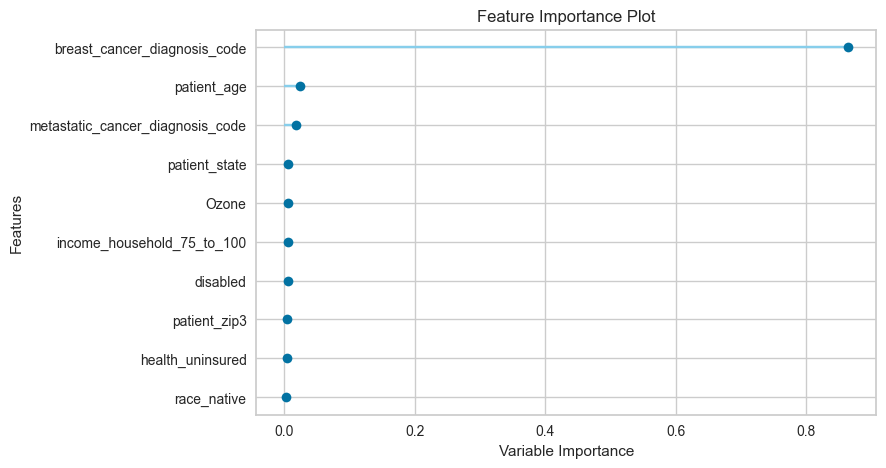

In [12]:
# Feature Importance
regression_exp.plot_model(best, plot = 'feature')

In [13]:
best

GradientBoostingRegressor(random_state=123)

In [14]:
# predict model on new_data
test = pd.read_csv('test.csv')
X_test = test.drop(columns=columns_to_drop)

predictions = regression_exp.predict_model(best, data = X_test)
predictions.head()

submission = pd.DataFrame({'patient_id': test['patient_id'], 'DiagPeriodL90D': predictions['prediction_label']})
submission.to_csv('submission.csv', index=False)